## Problem Statement:
Develop an automated system for extracting, comparing, and summarizing information from Indian government documents, including Prime Minister speeches, President speeches, Parliament Committee reports, and interim budget releases. The system should retrieve data from the following URLs:
- https://eparlib.nic.in
- https://sansad.in/ls/knowledge-centre/speeches

The system should be capable of:
1. **Information Retrieval**: Automatically fetch documents from the provided URLs, extracting text content from Prime Minister speeches, President speeches, Parliament Committee reports, and Interim Budget releases.

2. **Comparison Analysis**: Analyze the retrieved documents to identify common themes, trends, and differences between different types of speeches and reports. This could involve sentiment analysis, topic modeling, or any other relevant technique to compare the content.

3. **Text Summarization**: Summarize the extracted information into concise, coherent summaries. These summaries should capture the key points and main ideas presented in the documents, enabling users to quickly grasp the essential content without having to read through lengthy texts.

The developed system should be efficient, accurate, and user-friendly, providing valuable insights into the content of Indian government documents for various stakeholders such as researchers, policymakers, and the general public.

# Problem Resolution Approach

***Solution Strategy*** - Build a POC which should solve the following requirements:
- Extract key information, identify trends and comparisons, and generate concise summaries.
- Provide valuable insights for researchers, policymakers, and the public to understand government communication.

***Goal*** - Solving the above two requirements well in the POC would ensure that the accuracy of the overall model is good and therefore further improvisations and customizations make sense.

***Data Used*** -  Indian government documents rendered as PDF, stored in across 4 folders namely "Prime Minister Speech, President Speech, Parliment Committies, Interim Budget" respectively

***Tools used*** - LlamaIndex (only for now) has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

# System Design:

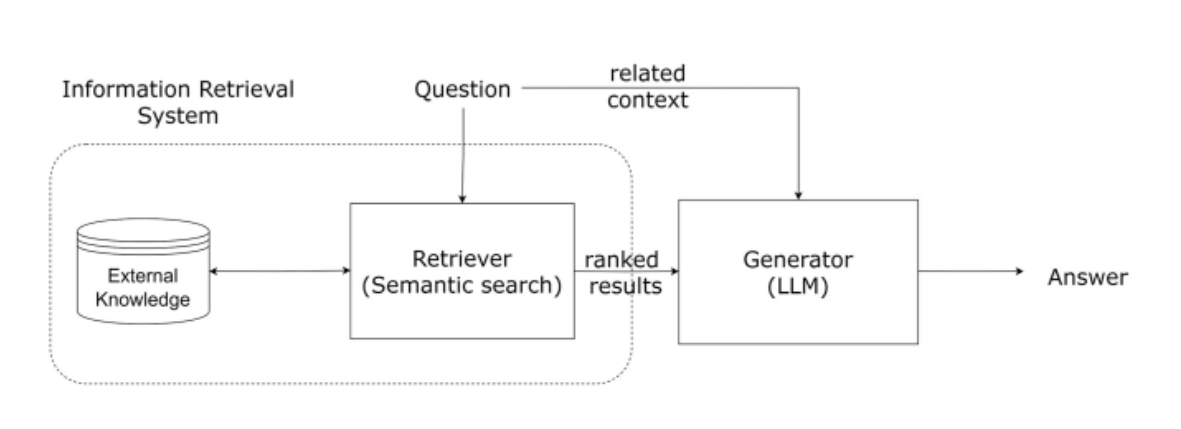

# 1. Import Necessary Libraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


llama-index-readers-file

In [2]:
!pip install llama-index llama-index-vector-stores-qdrant llama-index-llms-openai llama-index-embeddings-huggingface llama-index-question-gen-guidance guidance transformers qdrant_client ollama -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.5/257.5 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

# import necessary packages

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import openai
from google.colab import userdata
import logging
import sys
import os

import qdrant_client
from IPython.display import Markdown, display, HTML

openai.api_key = userdata.get('OpenAIKey')


from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    Settings,
    QueryBundle,
    KnowledgeGraphIndex,
    StorageContext
)

from llama_index.core.node_parser import SentenceSplitter

from llama_index.core import get_response_synthesizer

from llama_index.core.schema import IndexNode

from llama_index.core.tools import (
    QueryEngineTool, ToolMetadata
    )

from llama_index.llms.openai import OpenAI
# from llama_index.llms.ollama import Ollama

from llama_index.core.indices.list import SummaryIndex

from llama_index.core.query_engine import (
    SubQuestionQueryEngine,
    RouterQueryEngine,
    RetrieverQueryEngine)

from llama_index.core.callbacks import CallbackManager, LlamaDebugHandler

from llama_index.core.selectors import (
    PydanticMultiSelector,
    PydanticSingleSelector,
    LLMSingleSelector,
    LLMMultiSelector
)

from llama_index.question_gen.guidance import GuidanceQuestionGenerator

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

from llama_index.vector_stores.qdrant import QdrantVectorStore

# 2. Download Documents

### Simple Directory Reader

In [ ]:
budget_path = '/content/drive/Neerajkumar/GenAI - upGrad/Semantic Spotter - Assignment/data/Interim Budget'
parliment_committe_path = '/content/drive/Neerajkumar/GenAI - upGrad/Semantic Spotter - Assignment/data/Parliment Committies'
president_speech_path = '/content/drive/Neerajkumar/GenAI - upGrad/Semantic Spotter - Assignment/data/President Speech'
pm_speech_path = '/content/drive/Neerajkumar/GenAI - upGrad/Semantic Spotter - Assignment/data/Prime Minister Speech'

In [6]:
list_path = [budget_path, parliment_committe_path, president_speech_path, pm_speech_path]

all_docs = []

for dir_path in list_path:

  # Create a SimpleDirectoryReader object
  reader = SimpleDirectoryReader(input_dir=dir_path)

  # Load the data and append to documents list
  all_docs.append(reader.load_data())

### Using the Sentence splitter with Overlapping

In [7]:
# create parser
splitter = SentenceSplitter(
    chunk_size=512,
    chunk_overlap=20,
)

all_nodes = []

# parse document into nodes and extend to nodes list -- HEre we are not using append, as while creating storage vector, list of TextNodeTypes to be given.
for docs in all_docs:
  all_nodes.extend(splitter.get_nodes_from_documents(docs))

In [8]:
Settings.num_output = 512
Settings.context_window = 3900
Settings.chunk_size = 512

## Setting LLM other than openAI

In [9]:

# ollama
# Settings.llm = Ollama(model="mistral", request_timeout=30.0)

## Create Embedding & Index
For embedding useBAAI/bge-small-en-v1.5

In [10]:
# get API key and create embeddings
# bge embedding model - loads BAAI/bge-small-en-v1.5
Settings.embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

## Create a Qdrant Vector Store


## Initialise the QDrant Client

In [11]:
# Initialize the Qdrant Client
client = qdrant_client.QdrantClient(
    # you can use :memory: mode for fast and light-weight experiments,
    # it does not require to have Qdrant deployed anywhere
    # but requires qdrant-client >= 1.1.1
    location=":memory:"
    # otherwise set Qdrant instance address with:
    # uri="http://<host>:<port>"
    # set API KEY for Qdrant Cloud
    # api_key="<qdrant-api-key>",
)

### Create Collections using QDrant Client


### Creating Cache and main memory Collections

In [12]:
gov_vs = QdrantVectorStore(client=client, collection_name="gov_docs")# , enable_hybrid=True, batch_size=20)
gov_sc = StorageContext.from_defaults(vector_store=gov_vs)

In [13]:
# index for main
gov_si = SummaryIndex(all_nodes, storage_context=gov_sc)
gov_vi= VectorStoreIndex(all_nodes, storage_context=gov_sc)

## Configuring Query Engines

SummaryIndex and VectorStoreIndex. Each index contains nodes from different documents. The SummaryIndex is designed for summarisation, while the VectorStoreIndex  is for retrieving specific context.

Summary nodes contain summarised information, while vector store nodes contain the original context.

***`summary_query_engine`*** is configured using the summary_index and is set up for summarisation queries. It uses the `tree_summarize` response mode and can operate asynchronously.

***`vector_query_engine`*** is configured using the vector_index and is meant for retrieving specific context from the documents.

### Build the Query Engine with QDrant Index Store

In [14]:
# Have to give the openai's key -- else, will raise the error, as by default openai's llm is used for summarise
# Initialize a query engine for the index with a specified similarity top-k value
gov_sqe = gov_si.as_query_engine(response_mode="tree_summarize", similarity_top_k=1)
gov_vqe = gov_vi.as_query_engine(similarity_top_k=1)

###  Create Query Engine Tools

In [15]:
action_tools = [ToolMetadata(name='gov_summary', description=f'Useful for summarisation questions related to Government Documents'),
         ToolMetadata(name='gov_qa_retriever', description='Useful for retrieving specific context from Government Documents')]


In [16]:
query_engine_tools = [
    QueryEngineTool(
        query_engine=gov_sqe,
        metadata=action_tools[0]
    ),
    QueryEngineTool(
        query_engine=gov_vqe,
        metadata=action_tools[1]
    ),
]

## Creating Router Query Engine

In [17]:
# initialize router query engine (single selection, pydantic)
query_engine = RouterQueryEngine(
    selector=PydanticSingleSelector.from_defaults(),
    query_engine_tools=query_engine_tools,
)

## Function to get query response

In [18]:
## Query response function
def query_response(user_input):
  response = query_engine.query(user_input)
  final_response = response.response
  return final_response

In [19]:
def initialize_conv(user_input):
  print('Feel free to ask Questions regarding Government Documents. Press exit once you are done')
  while True:
    # user_input = input()
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(Markdown(f"<p style='font-size:15px'>Question: {user_input}</p><br><p style='font-size:10px'>Response:<br>{response}</p><br><br>"))
      # display(HTML(f"<p style='font-size:15px'>Question: {user_input}</p><br><p style='font-size:10px'>Response:<br>{response}</p><br><br>"))

In [ ]:
questions = [
    'list 5 main points in interim budget',
    'List similar points from speeches of prime minister and president',
    'exit'
]

for question in questions:
  initialize_conv(question)

Feel free to ask Questions regarding Government Documents. Press exit once you are done
